In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
# Import standard modules
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.set_cmap('jet')
import os
import pickle

<Figure size 432x288 with 0 Axes>

In [4]:
# Import torch modules
import torch
from torch import FloatTensor, cat, from_numpy
from torch.autograd import Variable
from torch.optim import Adam
from torchsummary import summary

In [5]:
import sys
sys.path.append('/data3/Astro/personal/yiminliu/cnnpca3d/')

In [6]:
# Import transform net
from transformer_net import TransformerNet

In [7]:
# Import utils function
from utils import dot_dict, load_model, parse_content_style_size, gram_matrix

In [8]:
# Import C3D model
from C3D_model import C3D, load_c3d_weights

#### 1. Specify options

In [9]:
device = 'cuda'

In [10]:
data_dir = '/data3/Astro/personal/yiminliu/models/3d_levee_wide_60x60x40_cond6w/'

In [11]:
args = {}
args['content_size'] = '40, 60, 60'
args['style_size'] = '40, 60, 60'
args['pca_model'] = os.path.join(data_dir, 'mpca_train3000_levee_wider_wellsonly_60x60x40_cond6w_l800.h5')
args['petrel_model'] = os.path.join(data_dir, 'facies_train3000_60x60x40_levee_wider_wellonlys_cond6w.h5')
args['rec_model'] = os.path.join(data_dir, 'mpca_rec3000_60x60x40_levee_wide_cond6w_l800_ptb70_std1.h5')
args['style_weight'] = 50.0
args['rec_weight'] = 500.0
args['epochs'] = 10
args['save_model'] = './saved_models/cnnpca_levee_wider_wellsonly_60x60x40_cond6w_l800_ptb70'
args['log_interval'] = 10
args['batch_size'] = 8
args['hd_file'] = os.path.join(data_dir, 'well_hd_wider_wellsonly.pickle')
args['hd_weight'] = 10.0
args['c3d_model'] = '/data3/Astro/personal/yiminliu/cnnpca3d/c3d.pickle'
args = dot_dict(args)

#### 2. Load data

In [12]:
args = parse_content_style_size(args)
content_size = args.content_size
style_size = args.style_size
print('content size:', content_size)
print('style size:', style_size)

content size: [40, 60, 60]
style size: [40, 60, 60]


In [13]:
# Load content model
m_pca =load_model(args.pca_model).astype(np.float32)
print(m_pca.max(), m_pca.min())
num_model = m_pca.shape[0]
m_pca = m_pca.reshape((num_model,1) + tuple(content_size))
m_pca.shape

5.1328125 -3.7636719


(3000, 1, 40, 60, 60)

In [14]:
# Load petrel generated data
fid = h5py.File(args.petrel_model, 'r')
m_cond = np.array(fid['data'])
fid.close()
m_cond = m_cond.transpose((0, -1, 1,2,3))
m_cond.shape

(3000, 1, 40, 60, 60)

In [15]:
fid = h5py.File(args.rec_model, 'r')
m_rec = np.array(fid['data'])
fid.close()
m_rec = m_rec.transpose((0, -1, 1,2,3))
m_rec.shape

(3000, 1, 40, 60, 60)

In [16]:
print(m_rec.max(), m_rec.min())

5.48 -3.045


In [17]:
print(m_cond.max(), m_cond.min())

2 0


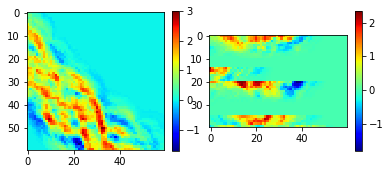

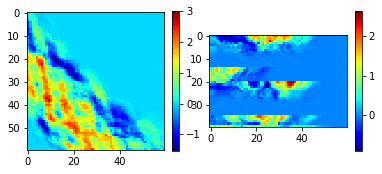

In [18]:
for k in range(2):
    plt.subplot(1,2,1)
    plt.imshow(m_pca[k, 0, 0, :, :])
    plt.colorbar(fraction=0.046)
    plt.subplot(1,2,2)
    plt.imshow(m_pca[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.show()

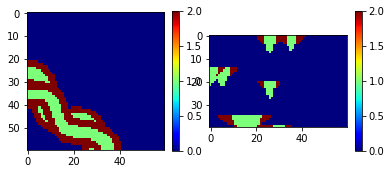

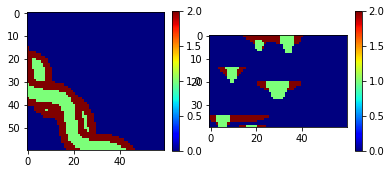

In [19]:
for k in range(2):
    plt.subplot(1,2,1)
    plt.imshow(m_cond[k, 0, 0, :, :])
    plt.colorbar(fraction=0.046)
    plt.subplot(1,2,2)
    plt.imshow(m_cond[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.show()

In [20]:
# Normalize data
max_, min_ = 2., 0.
m_pca = (m_pca - min_) / (max_ - min_) * 255.
print(m_pca.max(), m_pca.min())

654.4336 -479.86816


In [21]:
m_cond = ((m_cond - min_) / (max_ - min_)) * 255.
print(m_cond.max(), m_cond.min())

255.0 0.0


In [22]:
m_rec = ((m_rec - min_) / (max_ - min_)) * 255.
print(m_rec.max(), m_rec.min())

699.0 -388.2


In [23]:
# Load hard data
with open(args.hd_file, 'rb') as fid:
    well_hd = pickle.load(fid)
# Normalize well_hd
for wn in well_hd:
    well_hd[wn][:, -1] = (well_hd[wn][:,-1] - min_) / (max_ - min_) * 255.
# Assemble hard data into one single np.array
well_hd_all = np.concatenate(list(well_hd.values()), axis=0)
print('Total number of hard data:', well_hd_all.shape[0])

Total number of hard data: 240


#### 3. Construct C3D Net

In [24]:
c3d = C3D()
c3d.load_state_dict(load_c3d_weights(c3d, args.c3d_model))
c3d = c3d.to(device)
c3d.eval()

C3D(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

#### 4. Construct Transform Net

In [25]:
transformer = TransformerNet()
transformer = transformer.to(device)
summary(transformer, input_size=(1, 40, 60, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      CirularPad3d-1        [-1, 1, 42, 68, 68]               0
            Conv3d-2       [-1, 32, 40, 60, 60]           7,808
         ConvLayer-3       [-1, 32, 40, 60, 60]               0
       BatchNorm3d-4       [-1, 32, 40, 60, 60]              64
              ReLU-5       [-1, 32, 40, 60, 60]               0
      CirularPad3d-6       [-1, 32, 42, 62, 62]               0
            Conv3d-7       [-1, 64, 20, 30, 30]          55,360
         ConvLayer-8       [-1, 64, 20, 30, 30]               0
       BatchNorm3d-9       [-1, 64, 20, 30, 30]             128
             ReLU-10       [-1, 64, 20, 30, 30]               0
     CirularPad3d-11       [-1, 64, 22, 32, 32]               0
           Conv3d-12      [-1, 128, 20, 15, 15]         221,312
        ConvLayer-13      [-1, 128, 20, 15, 15]               0
      BatchNorm3d-14      [-1, 128, 20,

#### 6. Training

In [26]:
optimizer = Adam(transformer.parameters())
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()

In [27]:
num_batch = num_model // args.batch_size if num_model % args.batch_size == 0 else num_model // args.batch_size + 1
num_batch

375

In [28]:
def compute_hd_loss(y_pred, well_hd_all):
    ix = list(well_hd_all[:,0].astype('int'))
    iy = list(well_hd_all[:,1].astype('int'))
    iz = list(well_hd_all[:,2].astype('int'))
    v = Variable(torch.from_numpy(well_hd_all[:, -1]).float()).to(device)
    hd_loss = mae_loss(y_pred[:,0,iz,iy,ix], v)
    return hd_loss

In [29]:
for e in range(args.epochs):
    transformer.train()

    for ib in range(num_batch):
        optimizer.zero_grad()
        
        ind0, ind1 = ib * args.batch_size, min((ib+1) * args.batch_size, num_model)
        
        # Supervised step
        m_rec_var = Variable(torch.from_numpy(m_rec[ind0:ind1, ...]).float()).to(device)
        m_cond_var = Variable(torch.from_numpy(m_cond[ind0:ind1, ...]).float()).to(device)
        m_cond_pred_var = transformer(m_rec_var)
        rec_loss = args.rec_weight * mae_loss(m_cond_pred_var, m_cond_var)
        
        # Compute hard data loss
        hd_loss1 = args.hd_weight * compute_hd_loss(m_cond_pred_var, well_hd_all)
        
        # Unsupervised step
        m_pca_var = Variable(torch.from_numpy(m_pca[ind0:ind1, ...]).float()).to(device)
        m_pca_pred_var = transformer(m_pca_var).repeat(1, 3, 1, 1, 1)

        m_cond_var_img = Variable(m_cond_var.data.clone().repeat(1, 3, 1, 1, 1))
    
        features_m_pca_pred = c3d(m_pca_pred_var)
        features_m_cond = c3d(m_cond_var_img)

        style_loss = 0.
        for m in range(len(features_m_pca_pred)):
            gram_m_cond = gram_matrix(features_m_cond[m])
            gram_m_pca_pred = gram_matrix(features_m_pca_pred[m])
            
            style_loss += args.style_weight * mae_loss(gram_m_pca_pred, gram_m_cond)


        # Compute hard data loss
        hd_loss2 = args.hd_weight * compute_hd_loss(m_pca_pred_var, well_hd_all)

        total_loss = rec_loss + style_loss + hd_loss1 + hd_loss2
        total_loss.backward()
        optimizer.step()
        #
        if ib % args.log_interval == 0:
            print('Epoch{}, Batch {}/{}, Rec Loss {}, Style Loss {}, Hd Loss {}'
                  .format(e+1, ib+1, num_batch, rec_loss.item(), style_loss.item(), hd_loss1.item() + hd_loss2.item()))
    print('')
    torch.save(transformer.state_dict(), args.save_model + '_sw%.1f_rw%.1f_hw%.1f_%dep.model' 
               % (args.style_weight, args.rec_weight, args.hd_weight, e))

/data3/Astro/global/miniconda3/envs/pth-1.4/lib/python3.7/site-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([240])) that is different to the input size (torch.Size([8, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch1, Batch 1/375, Rec Loss 12268.5322265625, Style Loss 1032.1495361328125, Hd Loss 640.4630126953125
Epoch1, Batch 11/375, Rec Loss 12097.0361328125, Style Loss 1063.8199462890625, Hd Loss 575.3210144042969
Epoch1, Batch 21/375, Rec Loss 9626.6884765625, Style Loss 990.73291015625, Hd Loss 424.8486022949219
Epoch1, Batch 31/375, Rec Loss 9057.5546875, Style Loss 970.4661254882812, Hd Loss 385.4198455810547
Epoch1, Batch 41/375, Rec Loss 8739.87890625, Style Loss 995.1759033203125, Hd Loss 350.4622039794922
Epoch1, Batch 51/375, Rec Loss 8753.6416015625, Style Loss 1009.0568237304688, Hd Loss 328.1783752441406
Epoch1, Batch 61/375, Rec Loss 8507.267578125, Style Loss 997.8699951171875, Hd Loss 321.5499572753906
Epoch1, Batch 71/375, Rec Loss 8184.47216796875, Style Loss 1006.7682495117188, Hd Loss 296.4498748779297
Epoch1, Batch 81/375, Rec Loss 7564.86669921875, Style Loss 963.6823120117188, Hd Loss 278.6641540527344
Epoch1, Batch 91/375, Rec Loss 7520.1044921875, Style Loss 956.60

In [30]:
exit()